# Spectral Parameterization

***

![voyteklab](./data/voyteklab.png)

***

## Simulated and multi-dimensional data

Tutorial authored by Quirine Van Engen. Edited by Sydney Smith and Eena Kosik. 

<br>

You've just gone over how the SpecParam algorithm works on a single time-signal. However, most analyses usually include multiple electrodes and multiple conditions. Therefore, in this notebook, we'll simulate some data representing multiple epochs/trials from a single electrode and a single patient. Now, we can use "fooofgroup" to run the model on multiple power spectra within one function/fit. This will significantly speed up your coding and analysis. 

We suggest having your data in the time-domain in a 2D structure, in which each row represents a trial, and each column a time-point. Then, the power spectra can be created using the NeuroDSP library (which you have used earlier in this workshop). This will convert the data from the time-domain into the frequency-domain. Now the power spectra will also be in a 2D structure, in which each row still represents a trial, but each column now represents a frequency. This 2D structure can be used as input for the "fooofgroup" model.

(We suggest keeping different data structures for each condition)

There are 2 main methods for averaging when you're having multiple trial/epoched data:
1. You can create the power spectra for each trial, and average the power spectra per condition, per participant. Then the parameters the model extract will already be averaged too!
2. You can create the power spectra for each trial, then run the model on each power spectra. After this, you'll extract parameters for each trial and average those per condition and per participant.

Both methods are good, it depends on your research design which one is most suitable. For instance, if you have continous resting EEG data cut in epochs before or after a treatment, you can use option 1. Whereas option 1 will not be suitable if you want to compare the parameters before or after a certain event in your task. For this, you'd want to do single-trial baselining, thus option 2 will be more suitable for this situation.

In this notebook, we're using option 2

First, we need to import the necessary modules

In [1]:
# Standard python libaries
import numpy as np
import matplotlib.pyplot as plt

# From the NeuroDSP libaray
from neurodsp.utils import set_random_seed
from neurodsp.sim import sim_powerlaw, sim_oscillation
from neurodsp.spectral import compute_spectrum
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.plts.time_series import plot_time_series
from neurodsp.utils import create_times

# From the SpecParam (FOOOF) libaray
from fooof import FOOOFGroup
from fooof.analysis import get_band_peak_fg
from fooof.plts.spectra import plot_spectrum


## Let's start with just simulating 1 time series

In the cell below, we're creating 30 trials of data for 2 different conditions (these conditions are hypothetical, so they can be whatever you want them to be!)

In [2]:
# For simulations, I prefer to set the seed, so that every time I re-run this notebook, they will be the same
set_random_seed(0)

# Set standard settings for simulation
fs = 250  # the sampling frequency of the "recording"
n_seconds = 3  # the amount of seconds per epoch/trial 
times = create_times(n_seconds, fs)  # the axis containing the time in seconds (or miliseconds, check this later)

# Settings for periodic components
theta_freq = 4
alpha_freq = 10
theta_amplitude = 0.2
alpha_amplitude = 0.4

# settings for aperiodic components
exponent = -2.0

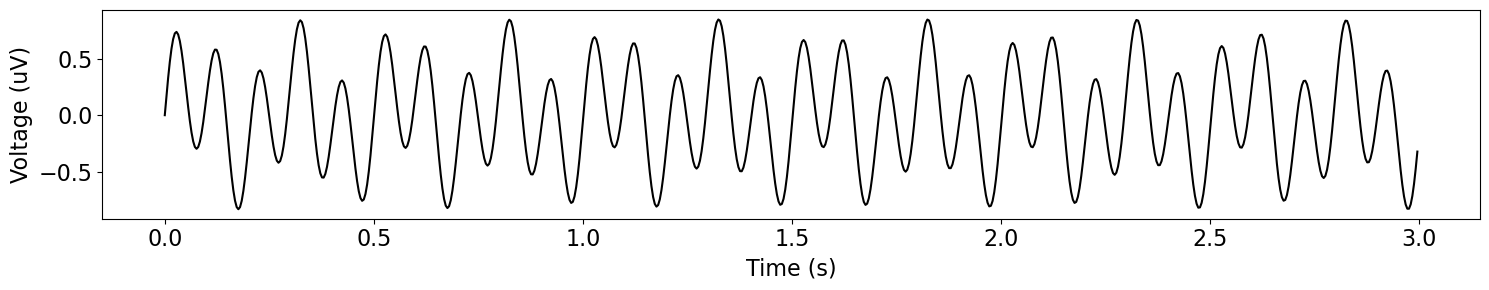

In [3]:
# Simulate a sinusoidal oscillation
periodic_theta = sim_oscillation(n_seconds=n_seconds, fs=fs, freq=theta_freq, cycle='sine') * theta_amplitude
periodic_alpha = sim_oscillation(n_seconds=n_seconds, fs=fs, freq=alpha_freq, cycle='sine') * alpha_amplitude

periodic = periodic_theta + periodic_alpha

plot_time_series(times, periodic)

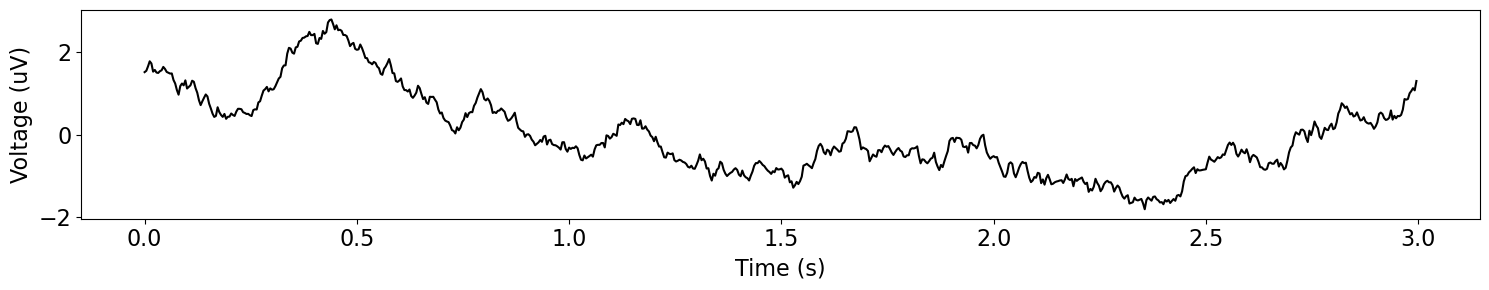

In [4]:
# Simulate aperiodic part of the signal
aperiodic = sim_powerlaw(n_seconds=n_seconds, fs=fs, exponent=exponent)

plot_time_series(times, aperiodic)

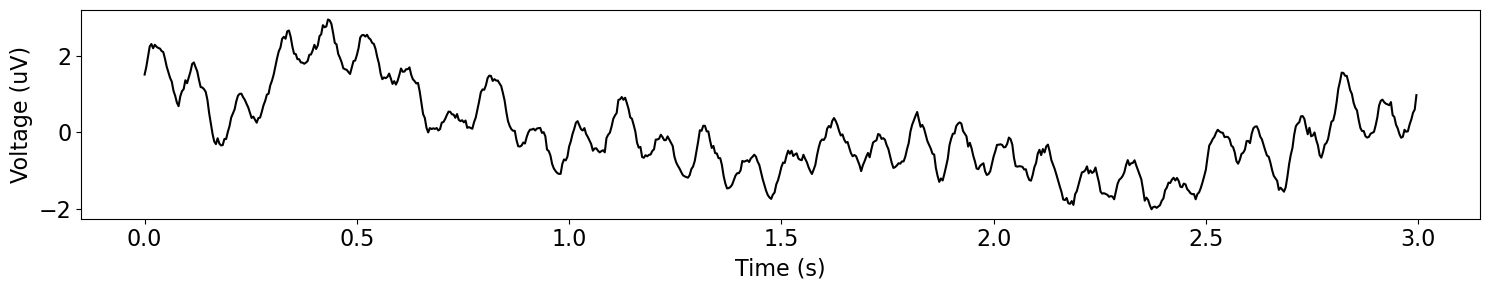

In [5]:
combined = periodic + aperiodic
plot_time_series(times, combined)

## Now, let's create multiple time-series (30 trials)



In [74]:
# For simulations, I prefer to set the seed, so that every time I re-run this notebook, they will be the same
set_random_seed(0)

# Set standard settings for simulation
fs = 250  # the sampling frequency of the "recording"
n_seconds = 3  # the amount of seconds per epoch/trial 
times = create_times(n_seconds, fs)  # the axis containing the time in seconds (or miliseconds, check this later)

# Settings for condition 1
theta_c1 = 5
alpha_c1 = 10
theta_amp_c1 = 0.2
alpha_amp_c1 = 0.4
exponent_c1 = -2.0

# Settigns for condition 2
theta_c2 = 6
alpha_c2 = 10
theta_amp_c2 = 0.4
alpha_amp_c2 = 0.3
exponent_c2 = -1.5

# Initialize empty numpy array to store time-series of 30 trials
n_timepoints = len(times)
n_trials = 30
condition_1 = np.full((n_trials, n_timepoints), np.nan)
condition_2 = np.full((n_trials, n_timepoints), np.nan)


# Now we'll be using a for-loop to create all the trials
for trial in range(0, n_trials):
    # Simulate periodic components
    # for condition 1
    periodic_theta_c1 = sim_oscillation(n_seconds=n_seconds, fs=fs, freq=theta_c1, cycle='sine') * theta_amp_c1
    periodic_alpha_c1 = sim_oscillation(n_seconds=n_seconds, fs=fs, freq=alpha_c1, cycle='sine') * alpha_amp_c1
    periodic_c1 = periodic_theta_c1 + periodic_alpha_c1
    # for condition 2
    periodic_theta_c2 = sim_oscillation(n_seconds=n_seconds, fs=fs, freq=theta_c2, cycle='sine') * theta_amp_c2
    periodic_alpha_c2 = sim_oscillation(n_seconds=n_seconds, fs=fs, freq=alpha_c2, cycle='sine') * alpha_amp_c2
    periodic_c2 = periodic_theta_c2 + periodic_alpha_c2
    
    # Simulate aperiodic components
    # for condition 1
    aperiodic_c1 = sim_powerlaw(n_seconds=n_seconds, fs=fs, exponent=exponent_c1)
    # for condition 2
    aperiodic_c2 = sim_powerlaw(n_seconds=n_seconds, fs=fs, exponent=exponent_c2)
    
    # Combine periodic and aperiodic components into one signal and add it to the numpy array
    condition_1[trial] = periodic_c1 + aperiodic_c1 
    condition_2[trial] = periodic_c2 + aperiodic_c2

#### Plot a subsection of the time seires of each condition to see whether the code worked

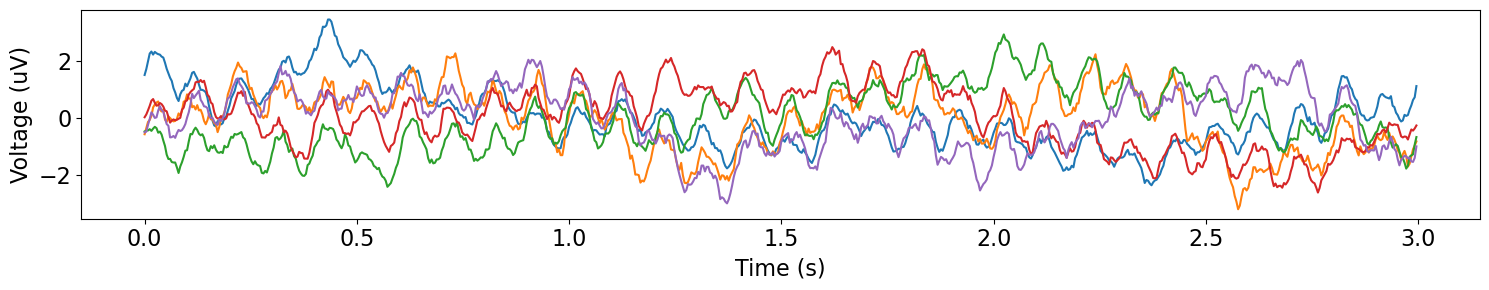

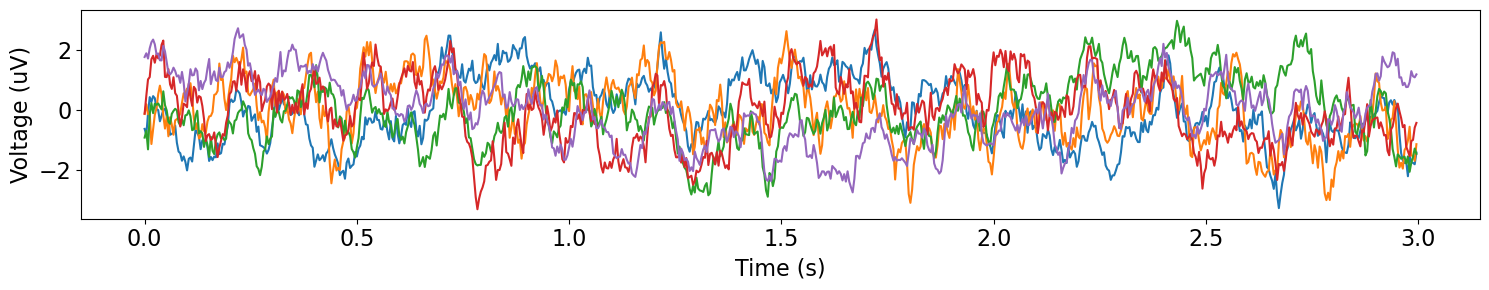

In [75]:
plot_time_series(times, condition_1[:5])  # We just need to transpose the matrix for plotting purposes
plot_time_series(times, condition_2[:5])

## Make power spectra

The function "compute_spectrum" can take in a 2D structure, and calculates the power spectra for each row. Remember that each row in "condition_1" and "condition_2" represents a trial in the time-domain.
This function also returns a paramater called "freqs". This is the frequency axis/resolution.

In [76]:
# Compute power spectra for both conditions
freq_c1, psd_c1 = compute_spectrum(condition_1, fs=fs, method='welch')
freq_c2, psd_c2 = compute_spectrum(condition_2, fs=fs, method='welch')

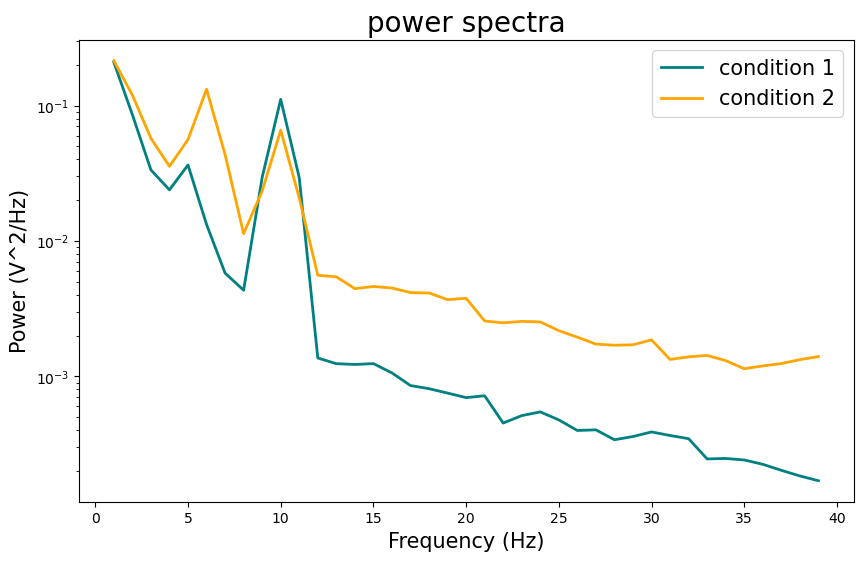

In [77]:
# Let's plot the average power spectrum of both conditions

plt.figure(figsize=(10,6))

# Create the lines
plt.semilogy(freq_c1[1:40], psd_c1.mean(axis=0)[1:40], color='teal', label='condition 1', lw=2)
plt.semilogy(freq_c2[1:40], psd_c2.mean(axis=0)[1:40], color='orange', label='condition 2', lw=2)

# Create title and axis labels
plt.title('power spectra', size=20)
plt.xlabel('Frequency (Hz)', size=15)
plt.ylabel('Power (V^2/Hz)', size=15)
plt.legend(loc=1, prop={'size': 15})
plt.show()

What are some differences you observe in the power spectra? Do they relate to your understanding of the parameters we set for simulating the conditions?

## Fit the SpecParam (fooof) model

Wow, that was pretty easy to create the power spectra for each trial and for both conditions!

Now, we have to create a model for both conditions using "FOOOFGroup". Then, we'll fit the model and extract the parameters we are interested in: aperiodic exponent and offset, theta & alpha aperiodic adjusted power, center frecuency, and band width.

We're also creating settings describing the model and choosing parameters to reduce both over- and under-fitting.

In [78]:
# In this case, we set a peak width limit to be higher than 2 frequencies wide AND smaller than 8 frequencies wide.
# Furthermore, we're setting a hard threshold minimum for the peak height to be considered an oscillation.
specparam_sets = {'peak_width_limits': [2, 8], 'min_peak_height': 0.1}
freq_range = [1, 40]

# Define the frequency ranges you consider to be theta or alpha oscillations
theta_range = [4, 8]
alpha_range = [8, 12]

# Initialize models
model_c1 = FOOOFGroup(**specparam_sets)
model_c2 = FOOOFGroup(**specparam_sets)

# Fit models
model_c1.fit(freq_c1, psd_c1, freq_range=freq_range)
model_c2.fit(freq_c2, psd_c2, freq_range=freq_range)

Running FOOOFGroup across 30 power spectra.
Running FOOOFGroup across 30 power spectra.


BONUS: If your computer or remote server is able to perform parallel processing, you can add an extra argument to .fit to speed up the proces: "n_jobs=-1"

This is possible since each power spectra is independent from the other since they are derived from different trials.

## Inspecting the model fits

Using the plot() command, we can inspect the model fits. SpecParam automatically calculates the model fit in 2 different measurements: 1) Error, 2) Rˆ2.

This plot will also show you all aperiodic fits and the center frequencies of the peaks it found.

We highly encourage you to always plot these figures, because they give you an initial glance at how accurate the model fits the data.

/Users/sydneysmith/opt/anaconda3/lib/python3.9/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


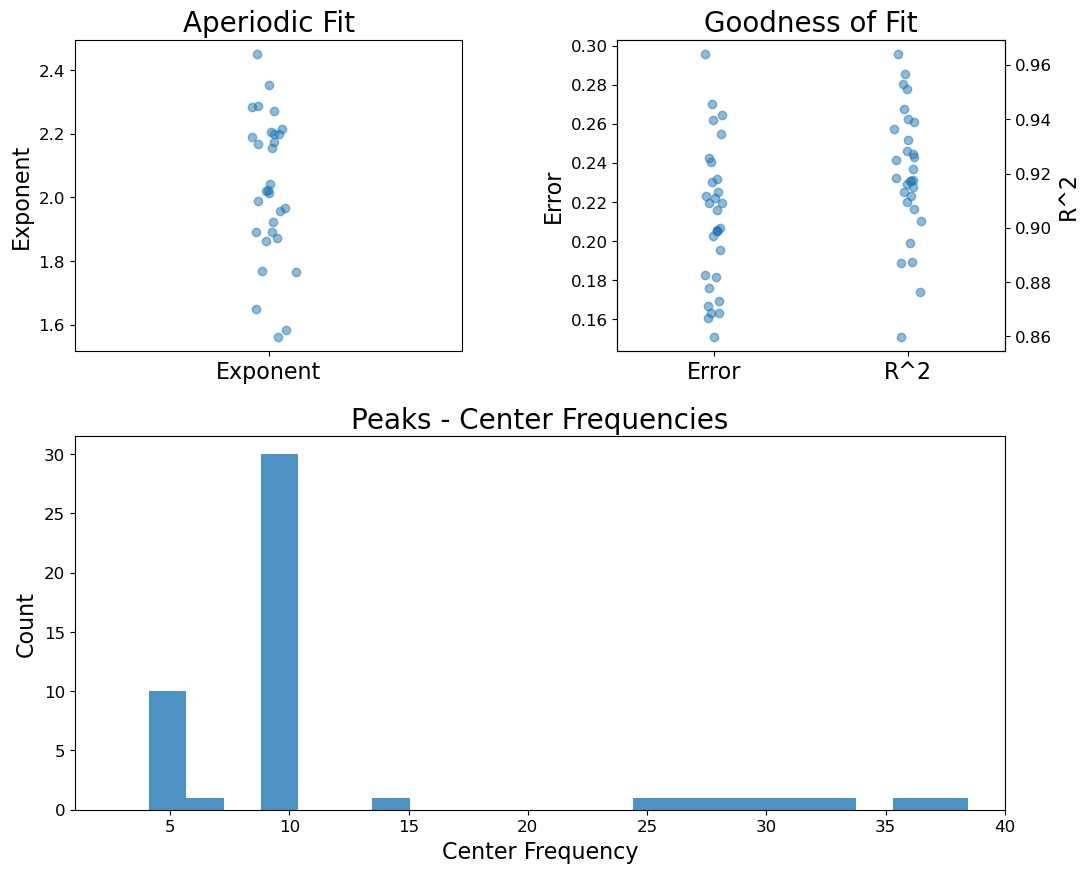

In [79]:
model_c1.plot()

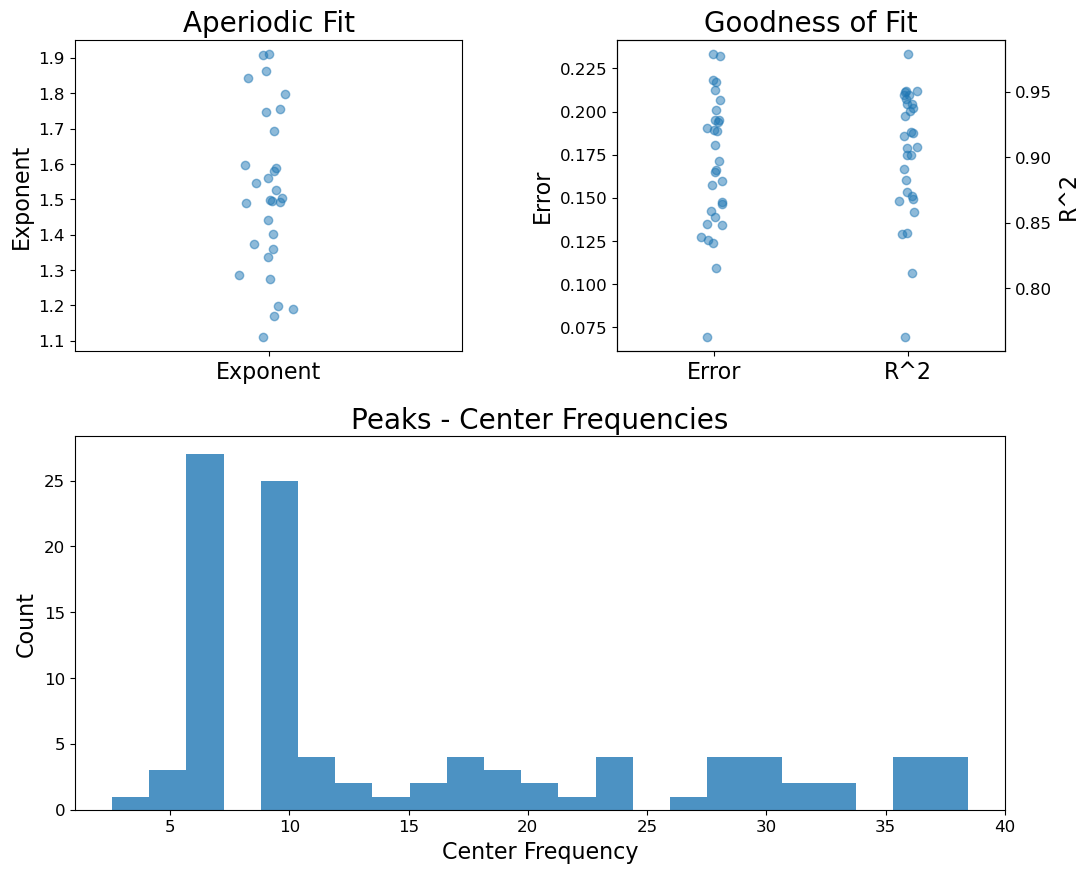

In [80]:
model_c2.plot()

### Extract and look at the parameters

In [81]:
# Extract the aperiodic parameters (exponent and offset)
exp_c1 = model_c1.get_params('aperiodic_params', 'exponent')
exp_c2 = model_c2.get_params('aperiodic_params', 'exponent')
offset_c1 = model_c1.get_params('aperiodic_params', 'offset')
offset_c2 = model_c2.get_params('aperiodic_params', 'offset')

# Extract the periodic paramaters (aperidic adjusted power, band width, center frequency)
theta_c1 = get_band_peak_fg(model_c1, band=theta_range)
theta_c2 = get_band_peak_fg(model_c2, band=theta_range)
alpha_c1 = get_band_peak_fg(model_c1, band=alpha_range)
alpha_c2 = get_band_peak_fg(model_c2, band=alpha_range)

In [82]:
# Let's see what our parameters look like. We have a list of all the exponents for condition 1 here, ordered by trials
exp_c1

array([2.17392682, 1.64958381, 2.01250836, 1.58240362, 2.15470914,
       1.76785826, 1.7655445 , 1.95582185, 1.9665455 , 1.87117853,
       2.28779937, 2.19855273, 2.19817532, 2.35502748, 2.16861421,
       1.86291352, 2.45139982, 1.56190738, 2.04350847, 2.27272008,
       2.28351275, 1.89031073, 2.02126572, 1.89172909, 2.02436546,
       1.92219091, 2.19086286, 1.98864504, 2.21488427, 2.20503337])

In [84]:
# Let's look at the theta parameters of condition 1.
# Here we see 3 columns and rows with the same amount as trials. 
# Look up the 'get_band_peak_fg' to see which parameter is which column ---> SPOILER:  [CF, PW, BW]
theta_c1

array([[       nan,        nan,        nan],
       [       nan,        nan,        nan],
       [       nan,        nan,        nan],
       [5.47805704, 0.74830571, 2.        ],
       [       nan,        nan,        nan],
       [4.81032901, 1.2156421 , 2.16172127],
       [5.71413738, 0.93814395, 2.10664856],
       [5.08592206, 0.91141624, 2.        ],
       [       nan,        nan,        nan],
       [5.11253106, 0.6870392 , 2.        ],
       [       nan,        nan,        nan],
       [       nan,        nan,        nan],
       [       nan,        nan,        nan],
       [       nan,        nan,        nan],
       [5.07562976, 0.96408247, 2.        ],
       [       nan,        nan,        nan],
       [       nan,        nan,        nan],
       [5.0287786 , 0.53983316, 3.49972575],
       [       nan,        nan,        nan],
       [       nan,        nan,        nan],
       [       nan,        nan,        nan],
       [5.36110192, 0.83613046, 2.91593866],
       [5.

Why do you think there are nan's in this array?

## Lastly, let's plot some of the differences in parameters between condition 1 and 2

In [85]:
# plotting function

def plot_feature_conditions(feature_c1, feature_c2):
        
    x1 = np.ones(len(feature_c1)) * 0.5
    x2 = np.ones(len(feature_c2)) * 1.5
    plt.scatter(x1+np.random.normal(-0.025,0.025,len(feature_c1)), feature_c1, color='teal', alpha=0.7)
    plt.scatter(x2+np.random.normal(-0.025,0.025,len(feature_c2)), feature_c2, color='orange', alpha=0.7)

    plt.plot([x1-0.1, x1+0.1], [np.nanmean(feature_c1), np.nanmean(feature_c1)], lw=7, c='teal')
    plt.plot([x2-0.1, x2+0.1], [np.nanmean(feature_c2), np.nanmean(feature_c2)], lw=7, c='orange')

    plt.xlim([0, 2])

    plt.xticks([x1[0], x2[0]], ["condition 1", "condition 2"])


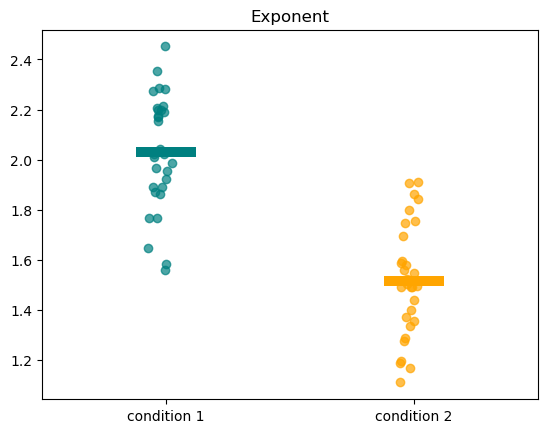

In [86]:
plot_feature_conditions(exp_c1, exp_c2)
plt.title('Exponent');

We can see that FOOOFGroup is able to capture the difference in aperiodic exponent in this simulated data. Condition 1 was simulated with an `exponent=2` and condition 2 was simualted with `exponent=1.5`. 

In [89]:
# To select the theta aperiodic adjusted power, select all rows from column 2
theta_pw_c1 = theta_c1[:,1]
theta_pw_c2 = theta_c2[:,1]

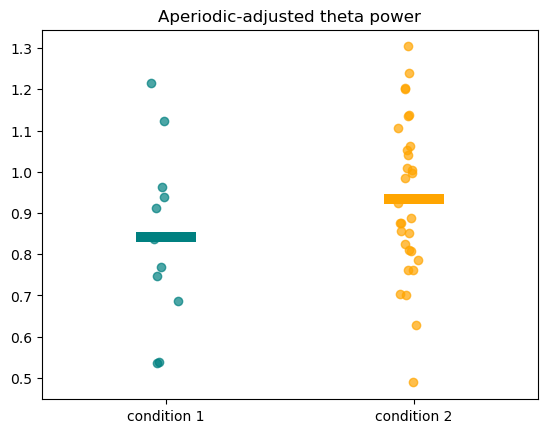

In [90]:
plot_feature_conditions(theta_pw_c1, theta_pw_c2)
plt.title('Aperiodic-adjusted theta power');

In [91]:
# To select the theta center frequency, select all rows from column 1
theta_cf_c1 = theta_c1[:,0]
theta_cf_c2 = theta_c2[:,0]

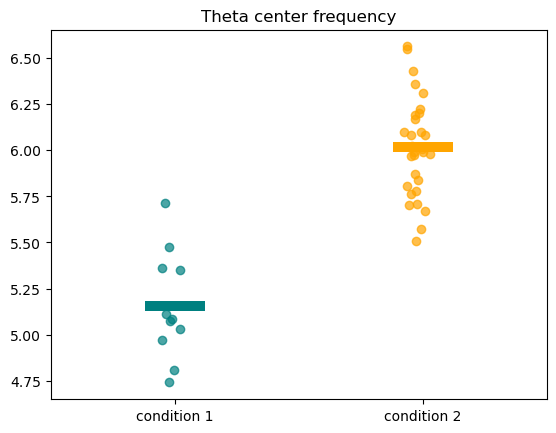

In [92]:
plot_feature_conditions(theta_cf_c1, theta_cf_c2)
plt.title('Theta center frequency');

You can plot more of the parameters if you want!

## Conclusion

In this notebook, we reviewed how to implement the spectral parameterization method using simulated data. We show how parameterizing power spectra can provide a description of both aperiodic and periodic components of a signal. 

This data, like the data you might collect and analyze, is multi-dimensional. The FOOOFGroup toolbox allows us to analyze this kind of data by applying the spectral parameterization method to large amounts of data at once. The data we simulated here is fairly simple and the sustained, high-amplitude oscillations it contains are quite different to the data you migh be working with. But the next notebook might be more exciting, since we'll be using actual intra-cranial data instead of simulated data!